# Demo: Back-end Part Test #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
import cv2
from sklearn.decomposition import PCA
from pylsd.lsd import lsd
from PIL import Image
import matplotlib.cm as cm
import json
from sklearn.cluster import DBSCAN 
from sklearn.linear_model import LinearRegression, RANSACRegressor      
from scipy.spatial.transform import Rotation as R  

### Step 1: Read dataset ###


In [2]:
entry = 'a6967d6c-9439-4d46-ba50-f2672d6fda55'  # good one!
# entry = 'f7f8a23d-2f95-486c-8487-53ebe22c86c6'
# entry = '5b0484d9-e493-4ec6-87a0-6a19be04709e'
# entry = '6a656b57-5605-46c4-9054-010dd2649fa1'
# entry = '5742d836-8b73-4d23-ac96-07904bbfed6f'  # good one!
# entry = 'a34b669d-72fd-457e-a0f9-e3463950faf5'  # good one!
# entry = 'bb14eff2-813f-47e3-95a5-a408cd378e9b'  # super bad one, a corner.
# entry = 'f3977b9d-609b-47a2-8292-a1b64e202df3'  # not bad and not good, in the corridor
# entry = '3716ab1b-ec61-4299-82a5-1f0c69fb0149'  # bad
# entry ='19173d43-17d3-4ebb-b0d5-7e9a4aec49e9'   # bad

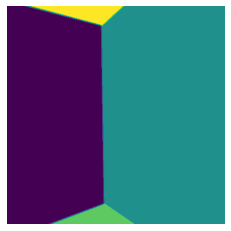

(400, 400)


In [3]:
# ST-roomnet results
data = np.load(f"report/saved_data/roomnet_{entry}.npy")
plt.imshow(data)
plt.axis('off')
plt.show()
print(data.shape)

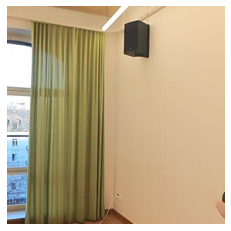

(400, 400, 3)


In [4]:
# Since the st-roomnet only acceptes image in a size of 400x400, crop the initial color image
image_path = f'report/color_{entry}.png'
img = Image.open(image_path)

img = img.convert('RGB')
width, height = img.size
crop_size = 400
left = max((width - crop_size) // 2, 0)
upper = max((height - crop_size) // 2, 0)
right = left + crop_size
lower = upper + crop_size
right = min(right, width)
lower = min(lower, height)
cropped_img = img.crop((left, upper, right, lower))
cropped_img_np = np.array(cropped_img)
plt.imshow(cropped_img_np)  # Use the cropped image as the background

plt.axis('off')
plt.show()
print(cropped_img_np.shape)

### Step 2: Find boundary lines in 2d (color image pixel coordinate system) ###

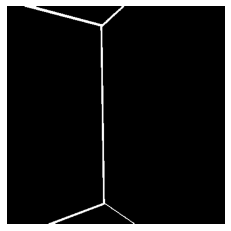

Number of Lines Detected: 15


In [5]:
# Find the boudaries
def Boundaries(roomnet_segmentation):
    roomnet_boundaries = find_boundaries(roomnet_segmentation, mode='thick', connectivity=1, background=0)

    boundary_image = (roomnet_boundaries.astype(np.uint8)) * 255

    kernel = np.ones((3,3), np.uint8)
    boundary_image = cv2.dilate(boundary_image, kernel, iterations=1)
    boundary_image = cv2.erode(boundary_image, kernel, iterations=1)
    plt.imshow(boundary_image, cmap='gray')
    plt.axis('off')
    plt.show()

    linesLSD = lsd(boundary_image.astype(np.float32))
    if linesLSD is None:
        lines = np.empty((0,4), dtype=int)
    else:
        lines = linesLSD[:, :4].astype(int) 
    print(f"Number of Lines Detected: {len(lines)}")

    return lines

initial_lines = Boundaries(data)

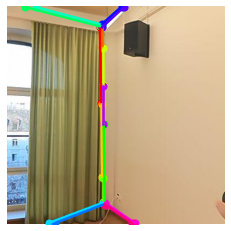

In [6]:
# Plot the found boundaries in real image
num_lines = len(initial_lines)
if num_lines > 0:
    cmap = cm.get_cmap('hsv')  # Choose a continuous colormap
    colors = [cmap(i / num_lines) for i in range(num_lines)]  # Normalize and sample colors
else:
    colors = []

plt.imshow(cropped_img_np)  # Use the cropped image as the background

for idx, line in enumerate(initial_lines):
    x1, y1, x2, y2 = line
    color = colors[idx]  # Assign a unique color to each line
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=2.5)
    plt.scatter([x1, x2], [y1, y2], color=color, s=50)
    # Optional: Uncomment to add text annotations
    # plt.text(x1, y1, f'({x1},{y1})', color='green', fontsize=6)
    # plt.text(x2, y2, f'({x2},{y2})', color='green', fontsize=6)

plt.axis('off')
plt.show()

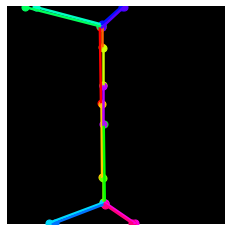

In [7]:
# Plot the found boundaries in black background
num_lines = len(initial_lines)
if num_lines > 0:
    cmap = cm.get_cmap('hsv')  # Choose a continuous colormap
    colors = [cmap(i / num_lines) for i in range(num_lines)]  # Normalize and sample colors
else:
    colors = []


plt.imshow(np.ones_like(data), cmap='gray')  

for idx, line in enumerate(initial_lines):
    x1, y1, x2, y2 = line
    color = colors[idx]  # Assign a unique color to each line
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=2.5)
    plt.scatter([x1, x2], [y1, y2], color=color, s=50)
plt.axis('off')
plt.show()

In [8]:
def group_lines_by_orientation_and_distance(initial_lines, orientation_threshold=15, distance_threshold=25):

    def line_orientation(line):
        x1, y1, x2, y2 = line
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        # Normalize angle to [0, 180)
        angle = angle % 180
        return angle

    def shortest_distance_between_segments(l1, l2):
        def point_line_segment_dist(px, py, ax, ay, bx, by):
            ABx, ABy = (bx - ax), (by - ay)
            APx, APy = (px - ax), (py - ay)
            magAB2 = ABx**2 + ABy**2
            if magAB2 == 0.0:
                return np.hypot(px - ax, py - ay)
            t = (APx * ABx + APy * ABy) / magAB2
            # Clamp t to [0, 1] so it lies on the segment
            t = max(0.0, min(1.0, t))
            # Projection coordinates
            projx = ax + t * ABx
            projy = ay + t * ABy
            return np.hypot(px - projx, py - projy)

        x1, y1, x2, y2 = l1
        x3, y3, x4, y4 = l2

        # Distances to check:
        d1 = point_line_segment_dist(x1, y1, x3, y3, x4, y4)
        d2 = point_line_segment_dist(x2, y2, x3, y3, x4, y4)
        d3 = point_line_segment_dist(x3, y3, x1, y1, x2, y2)
        d4 = point_line_segment_dist(x4, y4, x1, y1, x2, y2)

        return min(d1, d2, d3, d4)

    # --------------------------------------------------
    # 2. GROUP BY ORIENTATION
    # --------------------------------------------------
    orientation_groups = []  # Each element is (rep_angle, [list_of_lines])

    for line in initial_lines:
        angle_line = line_orientation(line)

        # Try to place the line into an existing orientation bin
        placed = False
        for idx, (rep_angle, lines_in_bin) in enumerate(orientation_groups):
            # Calculate minimal angular difference considering wrap-around at 180 degrees
            angle_diff = abs(angle_line - rep_angle)
            minimal_diff = min(angle_diff, 180 - angle_diff)

            if minimal_diff <= orientation_threshold:
                # If within orientation_threshold, add to this group
                lines_in_bin.append(line)
                placed = True
                break

        if not placed:
            # Create a new orientation group with this line
            orientation_groups.append((angle_line, [line]))

    # --------------------------------------------------
    # 3. SPLIT EACH ORIENTATION GROUP BY DISTANCE
    # --------------------------------------------------
    all_groups = []  # Will hold final groups across all orientation bins

    for rep_angle, lines_in_bin in orientation_groups:
        distance_groups = []  # Subgroups for lines with same orientation

        for line in lines_in_bin:
            found_group = False
            for dg in distance_groups:
                # If line is close (< distance_threshold) to any line in dg, add it
                if any(shortest_distance_between_segments(line, member) < distance_threshold for member in dg):
                    dg.append(line)
                    found_group = True
                    break

            if not found_group:
                # Create a new distance-based subgroup
                distance_groups.append([line])

        # Append all distance-based subgroups to the global list
        all_groups.extend(distance_groups)

    # --------------------------------------------------
    # 4. PLOT EACH GROUP IN A DIFFERENT COLOR
    # --------------------------------------------------
    plt.figure(figsize=(8, 8))
    plt.axis('equal')  # Keep x/y scale consistent if desired

    num_groups = len(all_groups)
    if num_groups > 0:
        cmap = cm.get_cmap('hsv')  # Continuous colormap
        colors = [cmap(i / num_groups) for i in range(num_groups)]
    else:
        colors = []

    for g_idx, group in enumerate(all_groups):
        group_color = colors[g_idx]
        for line in group:
            x1, y1, x2, y2 = line
            plt.plot([x1, x2], [y1, y2], color=group_color, linewidth=2)
            plt.scatter([x1, x2], [y1, y2], color=group_color, s=30)

    plt.title(f"Grouped Lines (Orientation ±{orientation_threshold}°, Dist < {distance_threshold})")
    plt.gca().invert_yaxis()  # Adjust based on image coordinate system
    plt.show()

    # Optionally, return all_groups if needed
    return all_groups

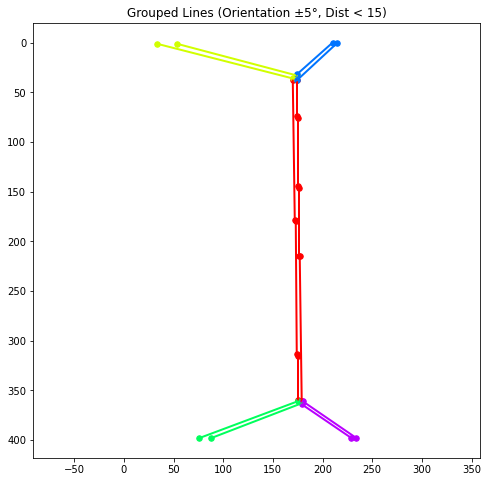

In [9]:
all_groups = group_lines_by_orientation_and_distance(initial_lines, orientation_threshold=5, distance_threshold=15)

In [10]:
def create_unique_lines_and_plot(all_groups, data):

    unique_lines = []

    for group in all_groups:
        if not group:
            continue  # Skip empty groups

        # Extract all endpoints from the group
        points = []
        for line in group:
            x1, y1, x2, y2 = line
            points.append((x1, y1))
            points.append((x2, y2))
        points = np.array(points)

        # Calculate the centroid of all points
        centroid = points.mean(axis=0)

        # Perform Principal Component Analysis (PCA) to find the main direction
        centered_points = points - centroid
        covariance_matrix = np.cov(centered_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        principal_component = eigenvectors[:, np.argmax(eigenvalues)]

        # Project all points onto the principal component
        projections = centered_points @ principal_component

        # Find the minimum and maximum projections
        min_proj = projections.min()
        max_proj = projections.max()

        # Calculate the endpoints of the representative line
        start_point = centroid + principal_component * min_proj
        end_point = centroid + principal_component * max_proj

        # Convert to integer coordinates and format as tuples of tuples
        unique_line = (
            (int(start_point[0]), int(start_point[1])),
            (int(end_point[0]), int(end_point[1]))
        )
        unique_lines.append(unique_line)

    print(f"Number of Unique Lines after Consolidation: {len(unique_lines)}")

    # # Plotting the unique lines with distinct colors
    # plt.figure(figsize=(8, 8))
    plt.imshow(cropped_img_np)  # Plot the base image

    num_unique = len(unique_lines)
    if num_unique > 0:
        cmap = cm.get_cmap('hsv', num_unique)  # Choose a colormap with enough distinct colors
        colors = [cmap(i) for i in range(num_unique)]  # Generate colors
    else:
        colors = []

    for idx, line in enumerate(unique_lines):
        (x1, y1), (x2, y2) = line
        color = colors[idx]
        plt.plot([x1, x2], [y1, y2], color=color, linewidth=3)
        plt.scatter([x1, x2], [y1, y2], color=color, s=30)

    plt.axis('off')
    plt.show()

    return unique_lines

Number of Unique Lines after Consolidation: 5


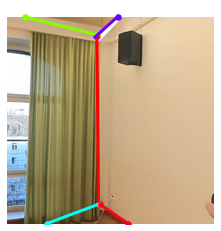

[((173, 37), (176, 361)), ((173, 34), (33, -1)), ((178, 361), (76, 399)), ((213, -1), (172, 36)), ((233, 399), (179, 362))]


In [11]:
unique_lines = create_unique_lines_and_plot(all_groups, data)
print(unique_lines)

In [12]:
# from shapely.geometry import LineString

# def remove_duplicate_lines_shapely(lines, distance_threshold=20):
#     unique_lines = []
#     shapely_lines = []
#     for line in lines:
#         ls = LineString([(line[0], line[1]), (line[2], line[3])])
#         if not any(ls.distance(existing_ls) < distance_threshold for existing_ls in shapely_lines):
#             unique_lines.append(tuple(sorted([(line[0], line[1]), (line[2], line[3])])))
#             shapely_lines.append(ls)
#     print(f"Number of Unique Lines after Removing Duplicates: {len(unique_lines)}")
#     return unique_lines

# unique_lines = remove_duplicate_lines_shapely(initial_lines)

In [13]:
# def remove_duplicate_lines(lines, distance_threshold=20):
#     unique_lines = []
#     for line in lines:
#         sorted_line = tuple(sorted([(line[0], line[1]), (line[2], line[3])]))
#         duplicate = any(
#             (np.linalg.norm(np.array(existing[0]) - np.array(sorted_line[0])) < distance_threshold and
#              np.linalg.norm(np.array(existing[1]) - np.array(sorted_line[1])) < distance_threshold)
#             for existing in unique_lines
#         )
#         if not duplicate:
#             unique_lines.append(sorted_line)
    
#     print(f"Number of Unique Lines after Removing Duplicates: {len(unique_lines)}")
#     return unique_lines

# unique_lines = remove_duplicate_lines(initial_lines)
# print(unique_lines)


In [14]:
# plt.figure(figsize=(8, 8))
# plt.imshow(np.ones_like(data), cmap='gray')  
# for line in unique_lines:
#     (x1, y1), (x2, y2) = line
#     plt.plot([x1, x2], [y1, y2], color='red', linewidth=1)
#     plt.scatter([x1, x2], [y1, y2], color='blue', s=10)
#     plt.text(x1, y1, f'({x1},{y1})', color='green', fontsize=6)
#     plt.text(x2, y2, f'({x2},{y2})', color='green', fontsize=6)
# plt.axis('off')
# plt.show()


# plt.figure(figsize=(8, 8))
# plt.imshow(data, cmap='gray')  
# for line in unique_lines:
#     (x1, y1), (x2, y2) = line
#     plt.plot([x1, x2], [y1, y2], color='red', linewidth=1)
#     plt.scatter([x1, x2], [y1, y2], color='blue', s=10)
#     plt.text(x1, y1, f'({x1},{y1})', color='green', fontsize=6)
#     plt.text(x2, y2, f'({x2},{y2})', color='green', fontsize=6)
# plt.axis('off')
# plt.show()


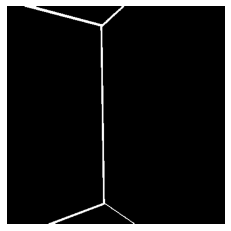

Number of Lines Detected: 15


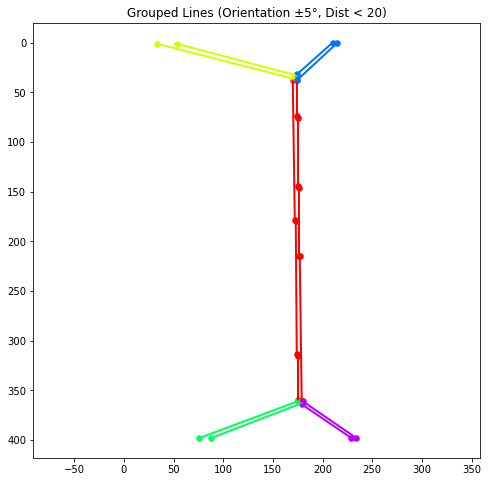

Number of Unique Lines after Consolidation: 5


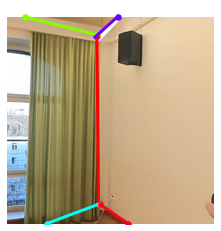

[((173, 37), (176, 361)), ((173, 34), (33, -1)), ((178, 361), (76, 399)), ((213, -1), (172, 36)), ((233, 399), (179, 362))]


In [15]:
# Merge 

def get_Boundaries_img(roomnet_segmentation, distance_threshold=10):
    lines = Boundaries(roomnet_segmentation)
    all_groups = group_lines_by_orientation_and_distance(lines, orientation_threshold=5, distance_threshold=20)
    unique_lines = create_unique_lines_and_plot(all_groups, roomnet_segmentation)
    return unique_lines

unique_lines_segments = get_Boundaries_img(data, distance_threshold=66)
print(unique_lines_segments)

### Step 3: Align depth information ###

In [16]:
def extract_intrinsics(camera):
    intrinsics = camera["intrinsics"]
    width = intrinsics["width"]
    height = intrinsics["height"]
    fov = intrinsics["fov"]
    focal_length = {
        "fx": intrinsics["focalLength"]["fx"],
        "fy": intrinsics["focalLength"]["fy"]
    }
    principal_point = {
        "cx": intrinsics["principalPoint"]["cx"],
        "cy": intrinsics["principalPoint"]["cy"]
    }
    return {
        "width": width,
        "height": height,
        "fov": fov,
        "focal_length": focal_length,
        "principal_point": principal_point
    }

def read_intrinsics(metadata_json_path):
    with open(metadata_json_path, 'r') as f:
        metadata = json.load(f)
    color_intrinsics = extract_intrinsics(metadata["color_camera"])
    depth_intrinsics = extract_intrinsics(metadata["depth_camera"])
    return color_intrinsics, depth_intrinsics

In [17]:
BASE_PATH = r"C:\\Users\\zoe\\Desktop\\mixed_reality\\Version3"

path_dict = {
    "backend_part": f"{BASE_PATH}\\BackendPart",
    "received_data": f"{BASE_PATH}\\report",
    "utils": f"{BASE_PATH}\BackendPart\\utils"
}

roomnet_weights_path = f"{path_dict['backend_part']}\\Weight_ST_RroomNet_ConvNext.h5"
roomnet_ref_img = f"{path_dict['utils']}\\ref_img2.png"
INDEX_FILE_PATH = f"{path_dict['received_data']}\\index.json"
COMBINED_VERSION2_PATH = path_dict["backend_part"]

def load_path(entry):
    metadata_json_path = f"{path_dict['received_data']}\\metadata_{entry}.json"
    depth_file_path = f"{path_dict['received_data']}\\flattened_{entry}.npy"
    # depth_file_path = f"{path_dict['received_data']}\\depth_{entry}.npy"
    color_image_path = f"{path_dict['received_data']}\\color_{entry}.png"
    return metadata_json_path, depth_file_path, color_image_path

metadata_json_path, depth_file_path, color_image_path = load_path(entry)
color_intrinsics, depth_intrinsics = read_intrinsics(metadata_json_path)

Depth data shape: (480, 544, 3)
Extracted real depth layer shape: (480, 544)
0.0
7.4648438


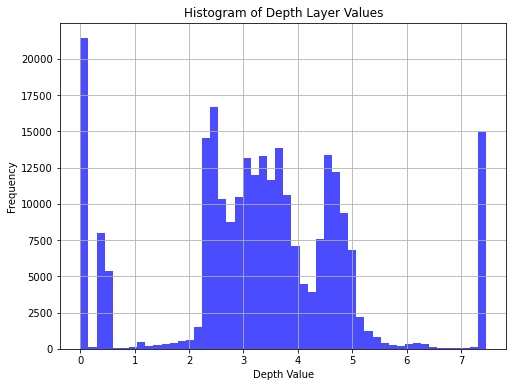

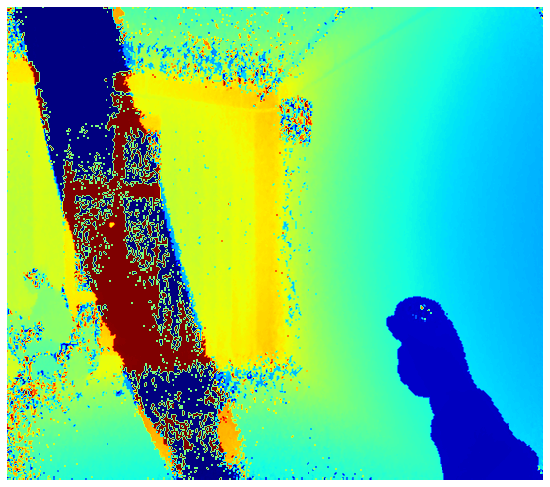

In [18]:
# Get an insight of depth information
bad_depth_data = np.load(depth_file_path)
print(f"Depth data shape: {bad_depth_data.shape}")
if bad_depth_data.ndim == 3:
    depth_data = bad_depth_data[:, :, -1]  # Extract the last layer
    print(f"Extracted real depth layer shape: {depth_data.shape}")
else:
    depth_data = np.load(depth_file_path)
 
print(depth_data.min())
print(depth_data.max())

# Plot histogram of the depth layer values
plt.figure(figsize=(8, 6))
plt.hist(depth_data.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Depth Layer Values")
plt.xlabel("Depth Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Plot the third layer as a depth image
plt.figure(figsize=(9.6, 10.88))
plt.imshow(depth_data, cmap='jet', interpolation='nearest')
plt.grid(False)
plt.axis('off')
plt.show()

In [19]:
# Align depth image and color image
def depth_to_point_cloud(depth, intrinsics):
    fx, fy = intrinsics['focal_length']['fx'], intrinsics['focal_length']['fy']
    cx, cy = intrinsics['principal_point']['cx'], intrinsics['principal_point']['cy']
    height, width = depth.shape

    i, j = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

    z = depth
    x = (j - cx) * z / fx
    y = (i - cy) * z / fy
    y += 0.3

    points = np.stack((x, y, z), axis=-1)
    valid_mask = points[..., 2] > 0

    return points, valid_mask, i, j

def project_to_image(points, intrinsics):
    fx, fy = intrinsics['focal_length']['fx'], intrinsics['focal_length']['fy']
    cx, cy = intrinsics['principal_point']['cx'], intrinsics['principal_point']['cy']

    x = points[..., 0]
    y = points[..., 1]
    z = points[..., 2]

    epsilon = 1e-6
    z_safe = np.where(z > 0, z, epsilon)

    u = (x * fx) / z_safe + cx
    v = (y * fy) / z_safe + cy
    u = np.round(u).astype(int)
    v = np.round(v).astype(int)

    return u, v

def align_depth_to_color(depth_data, depth_intrinsics, color_intrinsics):

    points, valid_depth_mask, i_indices, j_indices = depth_to_point_cloud(
        depth_data, 
        depth_intrinsics
    )
    
    color_u, color_v = project_to_image(points, color_intrinsics)
    
    color_height, color_width = color_intrinsics["height"], color_intrinsics["width"]
    aligned_depth = np.zeros((color_height, color_width), dtype=depth_data.dtype)

    flat_color_u = color_u.flatten()
    flat_color_v = color_v.flatten()
    flat_depth = depth_data.flatten()
    flat_valid_depth = valid_depth_mask.flatten()
    flat_i = i_indices.flatten()
    flat_j = j_indices.flatten()
    
    valid_projection_mask = (
        (flat_color_u >= 0) & (flat_color_u < color_width) &
        (flat_color_v >= 0) & (flat_color_v < color_height) &
        flat_valid_depth
    )
    
    depth_i = flat_i[valid_projection_mask]
    depth_j = flat_j[valid_projection_mask]
    
    color_i = flat_color_v[valid_projection_mask]
    color_j = flat_color_u[valid_projection_mask]
    
    aligned_depth[color_i, color_j] = depth_data[depth_i, depth_j]
    
    kernel = np.ones((3, 3), np.uint8)
    aligned_depth = cv2.morphologyEx(aligned_depth, cv2.MORPH_CLOSE, kernel)
    
    return aligned_depth

In [20]:
get_aligned_depth = align_depth_to_color(
    depth_data, 
    depth_intrinsics, 
    color_intrinsics
    )

# print(get_aligned_depth)
# print(get_aligned_depth.shape)
# print(get_aligned_depth.max())
# print(get_aligned_depth.min())

In [21]:
def crop_center(image, target_height, target_width):

    height, width = image.shape[:2]
    center_y, center_x = height // 2, width // 2

    start_y = max(center_y - target_height // 2, 0)
    start_x = max(center_x - target_width // 2, 0)

    end_y = start_y + target_height
    end_x = start_x + target_width

    return image[start_y:end_y, start_x:end_x]

In [22]:
def get_cropped_depth(depth_data, depth_intrinsics, color_intrinsics, crop_size=400):
   
    aligned_depth = align_depth_to_color(
    depth_data, 
    depth_intrinsics, 
    color_intrinsics
    )
    print(f"Aligned depth shape: {aligned_depth.shape}")

    cropped_depth = crop_center(aligned_depth, crop_size, crop_size)
    print(f"Cropped depth shape: {cropped_depth.shape}")
    return cropped_depth

In [23]:
cropped_depth = get_cropped_depth(depth_data, depth_intrinsics, color_intrinsics, crop_size=400)

Aligned depth shape: (480, 640)
Cropped depth shape: (400, 400)


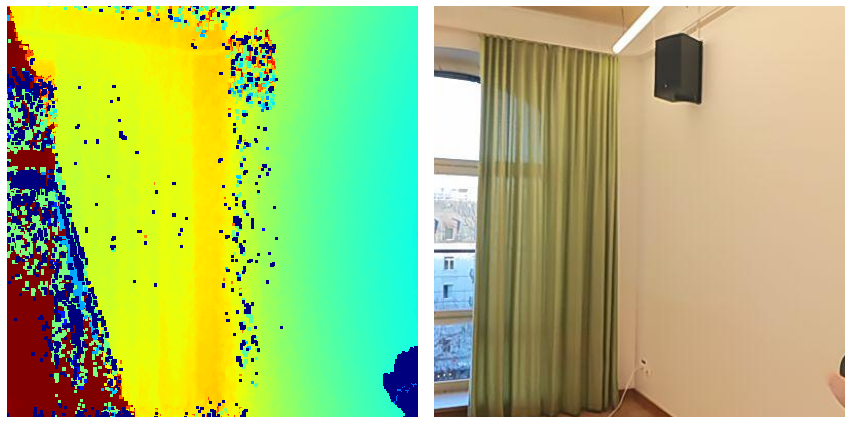

In [24]:
color_image_path = f"received_data/color_{entry}.png"
color_img = cv2.imread(color_image_path, cv2.IMREAD_COLOR)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cropped_depth, cmap='jet', interpolation='nearest')
plt.axis('off')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(cropped_img_np)
plt.axis('off')
plt.tight_layout()
plt.grid(False)
plt.show()

### Step 4: Get refined 3D lines ###

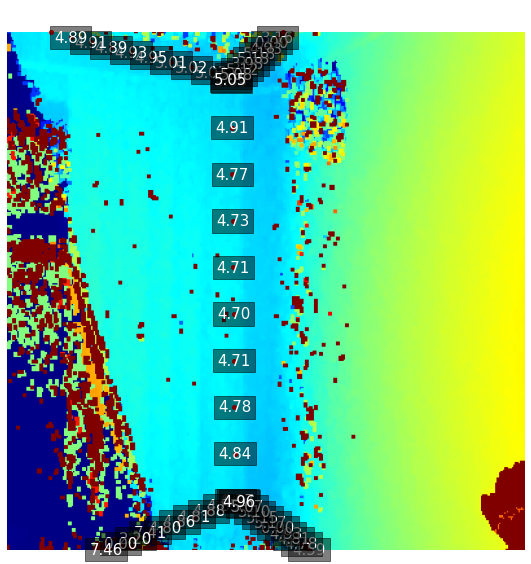

In [25]:
# Plot the unique lines inside the depth image for better visualization
def plot_lines_with_depth(cropped_depth, unique_line_segments, num_points=30):

    # Normalize the depth image for visualization
    depth_visual = (cropped_depth - np.min(cropped_depth)) / (np.max(cropped_depth) - np.min(cropped_depth))
    depth_visual = (depth_visual * 255).astype(np.uint8)
    depth_colored = cv2.applyColorMap(depth_visual, cv2.COLORMAP_JET)

    plt.figure(figsize=(10, 10))
    plt.imshow(depth_colored, cmap='jet')
    # plt.title("Cropped Depth with Line Points and Depths")

    for line in unique_line_segments:
        (x1, y1), (x2, y2) = line

        # Draw the line
        cv2.line(depth_colored, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 255, 255), thickness=2)

        # Divide the line into points
        x_points = np.linspace(x1, x2, num_points)
        y_points = np.linspace(y1, y2, num_points)

        for x, y in zip(x_points, y_points):
            # Get the depth value at each point
            x_int, y_int = int(round(x)), int(round(y))
            if 0 <= x_int < cropped_depth.shape[1] and 0 <= y_int < cropped_depth.shape[0]:
                depth = cropped_depth[y_int, x_int]
                plt.text(x, y, f"{depth:.2f}", color="white", fontsize=15, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))

            # Mark the point on the line
            plt.plot(x, y, 'ro', markersize=4)

    plt.axis('off')
    plt.show()

plot_lines_with_depth(cropped_depth, unique_lines_segments, num_points=10)

In [26]:
def extract_extrinsics(metadata):
    extrinsics = metadata["extrinsics"]

    position = {
        "x": extrinsics["position"]["x"],
        "y": extrinsics["position"]["y"],
        "z": extrinsics["position"]["z"]
    }

    # Extract rotation (quaternion)
    rotation = {
        "x": extrinsics["rotation"]["x"],
        "y": extrinsics["rotation"]["y"],
        "z": extrinsics["rotation"]["z"],
        "w": extrinsics["rotation"]["w"]
    }

    return {
        "position": position,
        "rotation": rotation
    }

with open(metadata_json_path, 'r') as file:
    metadata = json.load(file)

extrinsics = extract_extrinsics(metadata["color_camera"])

In [27]:
def transform_camera_to_world(extrinsics, point_camera):

    # Extract position and rotation
    position = extrinsics["position"]
    rotation = extrinsics["rotation"]

    # Convert quaternion to rotation matrix
    quat = [rotation["x"], rotation["y"], rotation["z"], rotation["w"]]
    rotation_matrix = R.from_quat(quat).as_matrix()

    p_camera = np.array([point_camera["x"], point_camera["y"], point_camera["z"]])
    p_world = rotation_matrix.dot(p_camera) + np.array([position["x"], position["y"], position["z"]])

    # Return as dictionary
    return {"x": p_world[0], "y": p_world[1], "z": p_world[2]}

In [28]:
def refine_line_z(points_camera_array, 
                 outlier_threshold=0.02, 
                 use_ransac=True, 
                 top_n=200,
                 clustering_eps=0.05,
                 clustering_min_samples=2):
    """
    Refines the z-values of a set of 3D points by fitting a line, removing outliers,
    and ensuring that proximate points in the x,y plane share the same depth value.

    Before refinement, selects the top_n points with the largest depth (z) values.

    Parameters:
    - points_camera_array: np.ndarray of shape (N, 3)
        The input array of 3D points (x, y, z).
    - outlier_threshold: float, optional (default=0.02)
        Threshold to determine outliers in z-values.
    - use_ransac: bool, optional (default=True)
        Whether to use RANSAC for robust line fitting.
    - top_n: int, optional (default=20)
        Number of top points to select based on largest z-values.
    - clustering_eps: float, optional (default=0.05)
        The maximum distance between two samples for one to be considered
        as in the neighborhood of the other in DBSCAN.
    - clustering_min_samples: int, optional (default=2)
        The number of samples in a neighborhood for a point to be considered
        as a core point in DBSCAN.

    Returns:
    - refined_points: np.ndarray of shape (min(N, top_n), 3)
        The refined set of 3D points after outlier removal and clustering.
    """
    if points_camera_array.shape[1] != 3:
        raise ValueError("Input points_camera_array must have shape (N, 3)")

    # Step 1: Select the top_n points with the largest z-values
    sorted_indices = np.argsort(points_camera_array[:, 2])[::-1]  # Descending order
    top_indices = sorted_indices[:top_n] if len(sorted_indices) >= top_n else sorted_indices
    top_points = points_camera_array[top_indices]

    # Extract x, y, z coordinates
    xs = top_points[:, 0]
    ys = top_points[:, 1]
    zs = top_points[:, 2]
    
    # Define the start and end points based on the sorted subset
    x_start, y_start = xs[0], ys[0]
    x_end, y_end = xs[-1], ys[-1]
    line_vec = np.array([x_end - x_start, y_end - y_start])
    line_length = np.linalg.norm(line_vec)
    if line_length < 1e-9:
        # If the line length is too small, return the top_points as is
        return top_points.copy()

    # Calculate the direction vector of the line
    line_dir = line_vec / line_length  
    dx, dy = line_dir

    # Project points onto the line to get parameter t
    ts = (xs - x_start) * dx + (ys - y_start) * dy

    if use_ransac:
        # Reshape ts for sklearn compatibility
        ts_reshape = ts.reshape(-1, 1)
        ransac = RANSACRegressor(LinearRegression(), 
                                 residual_threshold=outlier_threshold, 
                                 max_trials=100)
        ransac.fit(ts_reshape, zs)
        z_pred = ransac.predict(ts_reshape)
    else:
        # Median-based outlier removal
        z_median = np.median(zs)
        abs_dev = np.abs(zs - z_median)
        inliers_mask = abs_dev < outlier_threshold
        ts_in = ts[inliers_mask].reshape(-1, 1)
        zs_in = zs[inliers_mask]
        if len(zs_in) < 2:
            # Not enough inliers to fit a line; use original z-values
            z_pred = zs.copy()
        else:
            # Fit a linear regression to inliers
            lin_reg = LinearRegression()
            lin_reg.fit(ts_in, zs_in)
            z_pred = lin_reg.predict(ts.reshape(-1, 1))
    
    # Combine the original x and y with the refined z
    refined_points = np.column_stack((xs, ys, z_pred))

    # Step 2: Cluster points in the x,y plane to ensure proximate points share the same z
    # Define the feature space for clustering (x and y coordinates)
    xy_features = refined_points[:, :2]

    # Initialize DBSCAN with specified parameters
    dbscan = DBSCAN(eps=clustering_eps, min_samples=clustering_min_samples)
    cluster_labels = dbscan.fit_predict(xy_features)

    # Handle noise points (cluster_label == -1)
    # For noise points, we can choose to keep their z as is or handle them separately
    # Here, we'll keep their z values unchanged

    # Iterate over each cluster and assign the median z value to all points in the cluster
    unique_clusters = set(cluster_labels)
    for cluster in unique_clusters:
        if cluster == -1:
            # Noise point; skip or handle separately if needed
            continue
        # Find indices of points in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        # Compute the median z value for the cluster
        median_z = np.max(refined_points[cluster_indices, 2])
        # Assign the median z value to all points in the cluster
        refined_points[cluster_indices, 2] = median_z

    return refined_points



In [29]:
def extract_refined_3d_points(metadata, unique_line_segments, cropped_depth, intrinsics, num_points=15):
    extrinsics = extract_extrinsics(metadata["color_camera"])
   
    three_d_lines_world = []
    fx, fy = intrinsics['focal_length']['fx'], intrinsics['focal_length']['fy']
    cx, cy = intrinsics['principal_point']['cx'], intrinsics['principal_point']['cy']

    orig_width = intrinsics["width"]
    orig_height = intrinsics["height"]

    crop_size = 400
    center_x, center_y = orig_width // 2, orig_height // 2
    x1 = center_x - crop_size // 2
    y1 = center_y - crop_size // 2 
    
    all_colors = []
    line_id = 0

    for line in unique_line_segments:
        (x1_cropped, y1_cropped), (x2_cropped, y2_cropped) = line
        
        x_points = np.linspace(x1_cropped, x2_cropped, num_points)
        y_points = np.linspace(y1_cropped, y2_cropped, num_points)
        points_3d_camera = []

        for x_cropped, y_cropped in zip(x_points, y_points):
            x_int_cropped = int(round(x_cropped))
            y_int_cropped = int(round(y_cropped))
            if 0 <= x_int_cropped < cropped_depth.shape[1] and 0 <= y_int_cropped < cropped_depth.shape[0]:
                z = cropped_depth[y_int_cropped, x_int_cropped]-0.6
                if z > 0:
                    x_int_orig = x_int_cropped + x1
                    y_int_orig = y_int_cropped + y1
                    z = z
                    # X = (x_int_orig - cx) * z / fx
                    # Y = (y_int_orig - cy) * z / fy
                    point_camera = {"x": x_int_orig, "y": y_int_orig, "z": z}
                    points_3d_camera.append(point_camera)

        if len(points_3d_camera) >= 2:
            points_camera_array = np.array([[p['x'], p['y'], p['z']] for p in points_3d_camera])
            refined_line_points = refine_line_z(points_camera_array, outlier_threshold=0.01, use_ransac=True)

            interpolated_points_world = []
            for point in refined_line_points:
                point_camera = {"x": (point[0]-cx)*point[2]/fx, "y": (point[1]-cy)*point[2]/fy, "z": point[2]}
                point_world = transform_camera_to_world(extrinsics, point_camera)
                interpolated_points_world.append([point_world["x"], point_world["y"], point_world["z"]])

            three_d_lines_world.append(np.array(interpolated_points_world))
            all_colors.append(line_id)
            line_id += 1
            
    return three_d_lines_world

final_lines = extract_refined_3d_points(metadata, unique_lines_segments, cropped_depth,depth_intrinsics, num_points=500)


In [30]:
# Useful functions for the final step
def transform_world_to_camera(extrinsics, point_world):

    position = extrinsics["position"]
    rotation = extrinsics["rotation"]

    quat = [rotation["x"], rotation["y"], rotation["z"], rotation["w"]]
    rotation_matrix = R.from_quat(quat).as_matrix()

    p_world = np.array([point_world["x"], point_world["y"], point_world["z"]])

    p_camera = rotation_matrix.T.dot(p_world - np.array([position["x"], position["y"], position["z"]]))

    return {"x": p_camera[0], "y": p_camera[1], "z": p_camera[2]}

def project_camera_to_image(point_camera, intrinsics):

    fx, fy = intrinsics['focal_length']['fx'], intrinsics['focal_length']['fy']
    cx, cy = intrinsics['principal_point']['cx'], intrinsics['principal_point']['cy']

    X, Y, Z = point_camera["x"], point_camera["y"], point_camera["z"]


    if Z <= 0:
        return None  

    u = (X * fx / Z) + cx
    v = (Y * fy / Z) + cy

    return (u, v)

### Step 5: final generation (bad ideas, we used before) ###

In [ ]:
with open(metadata_json_path, 'r') as file:
    metadata = json.load(file)


def project_world_lines_to_image(three_d_lines_world, extrinsics, intrinsics, image_path, output_path=None):


    color_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if color_img is None:
        raise FileNotFoundError(f"Can not read: {image_path}")
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(color_img)
    plt.axis('off')


    cmap = plt.get_cmap('tab20')
    num_colors = len(three_d_lines_world)
    colors = [cmap(i / num_colors) for i in range(num_colors)]

    for idx, line_world in enumerate(three_d_lines_world):
        projected_points = []
        for point_world in line_world:
    
            point_world_dict = {"x": point_world[0], "y": point_world[1], "z": point_world[2]}

            point_camera = transform_world_to_camera(extrinsics, point_world_dict)

            uv = project_camera_to_image(point_camera, intrinsics)
            if uv is not None:
                projected_points.append(uv)
        
        if len(projected_points) >= 2:

            projected_points = np.array(projected_points)

            u, v = projected_points[:,0], projected_points[:,1]
            valid_mask = (u >= 0) & (u < intrinsics["width"]) & (v >= 0) & (v < intrinsics["height"])
            u, v = u[valid_mask], v[valid_mask]
            if len(u) >= 2:
                plt.plot(u, v, color=colors[idx], linewidth=5, label=f'Line {idx+1}' if idx < 20 else None)

    # if num_colors > 0:
    #     plt.legend(loc='upper right', fontsize=14, ncol=3)

    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


# metadata = metadata
# # unique_line_segments = unique_lines_segments
# cropped_depth = cropped_depth
# intrinsics = color_intrinsics
# plot = True

color_image_path = f"received_data/color_{entry}.png"
project_world_lines_to_image(
        three_d_lines_world=final_lines,
        extrinsics=metadata["color_camera"]["extrinsics"],  
        intrinsics=color_intrinsics,
        image_path=color_image_path,
        output_path=None  
    )


### Step 6: Final generation (good ideas, our final output in the report) ###

In [31]:
def fit_line_pca(points):

    C = np.mean(points, axis=0)
    X_centered = points - C
    
    pca = PCA(n_components=1)
    pca.fit(X_centered)
    
    D = pca.components_[0]
    ts = X_centered.dot(D)
    
    t_min, t_max = ts.min(), ts.max()
    
    start_point = C + t_min * D
    end_point = C + t_max * D
    
    line_segment = np.vstack((start_point, end_point))
    
    return line_segment

def generate_final_lines(three_d_lines_world):

    final_lines = []
    for idx, line_points in enumerate(three_d_lines_world):
        if line_points.shape[0] < 2:
            print(f"Line {idx} has less than 2 points. Skipping.")
            continue
        line_segment = fit_line_pca(line_points)
        final_lines.append(line_segment)
    return final_lines

if __name__ == "__main__":
    metadata = metadata
    unique_line_segments = unique_lines_segments
    cropped_depth = cropped_depth
    intrinsics = color_intrinsics
    plot = True

    
    three_d_lines_world = extract_refined_3d_points(
        metadata, unique_line_segments, cropped_depth, intrinsics, num_points=15
    )
    
    final_lines_bad = generate_final_lines(three_d_lines_world)

    print(f"Number of final lines: {len(final_lines)}")
    for i, line in enumerate(final_lines):
        print(f"Final Line {i}: Shape {line.shape}")
        print(f"Final Line {i}: Start Point: {line[0]}, End Point: {line[1]}")
    

Number of final lines: 5
Final Line 0: Shape (200, 3)
Final Line 0: Start Point: [ 5.14353996 -0.15571646  1.05851319], End Point: [ 5.14353996 -0.15571646  1.05851319]
Final Line 1: Shape (200, 3)
Final Line 1: Start Point: [ 5.28783268 -0.29760338  1.08612574], End Point: [ 5.28783268 -0.29760338  1.08612574]
Final Line 2: Shape (200, 3)
Final Line 2: Start Point: [8.03835823 5.43023922 2.55729775], End Point: [7.92755282 5.28782543 2.16964231]
Final Line 3: Shape (200, 3)
Final Line 3: Start Point: [ 5.41681983 -0.63542833  0.67359745], End Point: [ 5.41681983 -0.63542833  0.67359745]
Final Line 4: Shape (200, 3)
Final Line 4: Start Point: [5.24251784 3.97443865 0.80897864], End Point: [5.24251784 3.97443865 0.80897864]


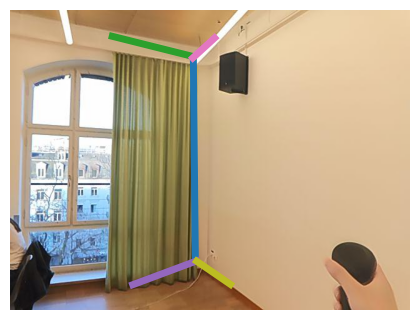

In [32]:
def project_world_lines_to_image(three_d_lines_world, extrinsics, intrinsics, image_path, output_path=None):
    color_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if color_img is None:
        raise FileNotFoundError(f"Cannot read: {image_path}")
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

    # Set figure size and DPI to achieve a 400x400 pixel image
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    ax.imshow(color_img)
    ax.axis('off')

    cmap = plt.get_cmap('tab20')
    num_colors = len(three_d_lines_world)
    colors = [cmap(i / num_colors) for i in range(num_colors)]

    for idx, line_world in enumerate(three_d_lines_world):
        projected_points = []
        for point_world in line_world:
            point_world_dict = {"x": point_world[0], "y": point_world[1], "z": point_world[2]}

            point_camera = transform_world_to_camera(extrinsics, point_world_dict)

            uv = project_camera_to_image(point_camera, intrinsics)
            if uv is not None:
                projected_points.append(uv)
        
        if len(projected_points) >= 2:
            projected_points = np.array(projected_points)
            u, v = projected_points[:,0], projected_points[:,1]
            valid_mask = (u >= 0) & (u < intrinsics["width"]) & (v >= 0) & (v < intrinsics["height"])
            u, v = u[valid_mask], v[valid_mask]
            if len(u) >= 2:
                ax.plot(u, v, color=colors[idx], linewidth=5, label=f'Line {idx+1}' if idx < 20 else None)

    # if num_colors > 0 and num_colors <= 20:
    #     ax.legend(loc='upper right', fontsize=8, ncol=2)

    # Adjust layout to remove any padding and ensure the image is exactly 400x400 pixels
    plt.tight_layout(pad=0)

with open(metadata_json_path, 'r') as file:
    metadata = json.load(file)

# Assuming final_lines_bad is defined elsewhere
project_world_lines_to_image(
    three_d_lines_world=final_lines_bad,
    extrinsics=metadata["color_camera"]["extrinsics"],  
    intrinsics=color_intrinsics,
    image_path=color_image_path,
    output_path=None  # Specify output path if needed
    )
